In [ ]:
!pip install gensim
!pip install fasttext

In [ ]:
!wget 'https://dumps.wikimedia.org/idwiki/latest/idwiki-latest-pages-articles.xml.bz2'

--2020-08-25 05:08:11--  https://dumps.wikimedia.org/idwiki/latest/idwiki-latest-pages-articles.xml.bz2
Resolving dumps.wikimedia.org (dumps.wikimedia.org)... 208.80.154.7, 2620:0:861:1:208:80:154:7
Connecting to dumps.wikimedia.org (dumps.wikimedia.org)|208.80.154.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 618753807 (590M) [application/octet-stream]
Saving to: ‘idwiki-latest-pages-articles.xml.bz2’

idwiki-latest-pages 100%[===================>] 590.09M  4.76MB/s    in 2m 3s   

2020-08-25 05:10:15 (4.79 MB/s) - ‘idwiki-latest-pages-articles.xml.bz2’ saved [618753807/618753807]



In [ ]:
from gensim.corpora import WikiCorpus
from time import time

now = time()
dataset = WikiCorpus("idwiki-latest-pages-articles.xml.bz2", \
                     lemmatize=False, dictionary={})
print('Done loading datasets')

with open("wiki-id-formatted.txt", 'w', encoding="utf8") as output:
    counter = 0
    for text in dataset.get_texts():
        output.write(' '.join(text)+"\n")
        counter += 1
        if counter % 10000 == 0:
            print(counter, 'data done')

print('Done in %.2fs' % (time() - now))

In [ ]:
!zip corpus.zip wiki-id-formatted.txt 

  adding: wiki-id-formatted.txt (deflated 70%)


# Preparation

In [171]:
import pandas as pd

tra = pd.read_csv('drive/My Drive/Kompetisi/Data Mining Gemastik 19/' \
                    'Data_A_UKARA/data_train_A.csv')
val  = pd.read_csv('drive/My Drive/Kompetisi/Data Mining Gemastik 19/' \
                   'Data_A_UKARA/data_dev_A.csv')
tes = pd.read_csv('drive/My Drive/Kompetisi/Data Mining Gemastik 19/' \
                    'Data_A_UKARA/data_test_A.csv')

print(tra.head(), val.head(), tes.head(), sep='\n\n')

x_tra, y_tra = tra['RESPONSE'].values, tra['LABEL'].values
x_val, y_val = val['RESPONSE'].values, val['LABEL'].values
x_tes, y_tes = tes['RESPONSE'].values, tes['LABEL'].values

y_tra = y_tra.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_tes = y_tes.reshape(-1, 1)

print('\n', len(x_tra), len(x_val), len(x_tes))

  RES_ID                                           RESPONSE  LABEL
0   TRA1  intetraksi/beradaptasi terhadap lingkungan yan...      1
1   TRA2         seperti jatuhnya meteor tsunami gempa bumi      0
2   TRA3      hanya tuhan yang tahu tantangan nya itu apaan      0
3   TRA4                      mereka akan sulit beradaptasi      1
4   TRA5             Tempat tinggal, ekonomi, dan pekerjaan      1

  RES_ID                                           RESPONSE  LABEL
0  DEVA1  karena di tempat tnggalnya tidak aman karena b...      0
1  DEVA2  banyak yang menolak, susah mencari lapangan pe...      1
2  DEVA3  ah berkomunikasi dengan wilyah yang mereka tem...      1
3  DEVA4  tantangan yang akan mereka hadapi, seperti mer...      1
4  DEVA5      Mereka akan tidak terbiasa dengan tempat baru      1

  RES_ID                                           RESPONSE  LABEL
0   TSA1  beradaptasi dengan lingkunagn baru, lahan dan ...      1
1   TSA2  Pengungsi akan mencari mata pencaharian yang b... 

In [7]:
# class distribution
import numpy as np

print(np.bincount(y_tra.ravel()))
print(np.bincount(y_val.ravel()))
print(np.bincount(y_tes.ravel()))

[ 77 191]
[ 62 153]
[245 610]


# Generate Word List

In [ ]:
!pip install sastrawi

In [29]:
import sys
import csv
import numpy as np
import pandas as pd
# import Sastrawi
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [174]:
import json

tokenizer_tr = Tokenizer()
tokenizer_tr.fit_on_texts(np.hstack([x_tra, x_val]))

tokenizer_te = Tokenizer()
tokenizer_te.fit_on_texts(np.array(x_tes, dtype='str'))

f = open('word_index_train.json', 'w')
g = open('word_index_test.json', 'w')
json.dump(tokenizer_tr.word_index, f)
json.dump(tokenizer_te.word_index, g)
f.close()
g.close()

In [ ]:
!head word_index_test.json

# Prepare Embedding Matrix

In [181]:
path = 'drive/My Drive/Kompetisi/Permutasi/emb_train.npz'
matrix_tr = np.load(path, allow_pickle=True)
matrix_tr = matrix_tr['matrix']

path = 'drive/My Drive/Kompetisi/Permutasi/emb_test.npz'
matrix_te = np.load(path, allow_pickle=True)
matrix_te = matrix_te['matrix']

In [204]:
seq_tra = tokenizer_tr.texts_to_sequences(x_tra)
seq_val = tokenizer_tr.texts_to_sequences(x_val)

pad_tra = pad_sequences(seq_tra)
pad_val = pad_sequences(seq_val)

# Training Phase

In [236]:
class FastText(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim, mask_zero=False, **kwargs):
        super(FastText, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.mask_zero = mask_zero

    def build(self, input_shape):
        embeddings = tf.Variable(matrix_tr, trainable=False)
        self.embeddings = embeddings

    def call(self, inputs):
        return tf.nn.embedding_lookup(self.embeddings, inputs)

    def compute_mask(self, inputs, mask=None):
        if not self.mask_zero:
            return None
        return tf.not_equal(inputs, 0)

# model arch
inputs = tf.keras.layers.Input(shape=(None,), name='input', dtype='int32')
layer = FastText(matrix_tr.shape[0], 300, mask_zero=True, name='emb')(inputs)
lstm = tf.keras.layers.LSTM(32, name='lstm')(layer)
dense = tf.keras.layers.Dense(1, activation='sigmoid', name='dense')(lstm)
model = tf.keras.models.Model(inputs=inputs, outputs=dense, name='model')

# training setup
step = tf.Variable(0, trainable=False)
boundaries = [50, 100]
values = [0.1, 0.05, 0.02]
learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

prec = Precision(name='prec')
rec = Recall(name='rec')
metrics = ['acc', prec, rec]
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model.summary()

model.save_weights('drive/My Drive/Kompetisi/Permutasi/weights.hdf5')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None)]            0         
_________________________________________________________________
emb (FastText)               (None, None, 300)         277800    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                42624     
_______________________________

In [ ]:
mean = x_tra.shape[0] / 2
class_weight = {0: mean / 77, 1: mean / 191}

epochs = 200
hist = model.fit(pad_tra, y_tra, epochs=epochs, batch_size=512, verbose=0, \
                 validation_data=(pad_val, y_val), class_weight=class_weight)

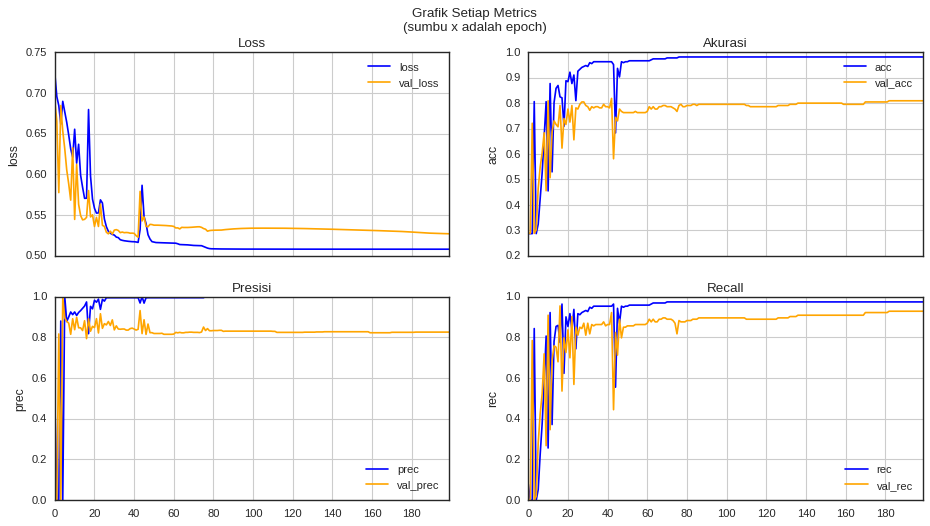

In [235]:
def plot_ax(axes, metrics, title):
    val_met = 'val_' + metrics
    axes.plot(hist.history[metrics], c='blue', linewidth=1.5)
    axes.plot(hist.history[val_met], c='orange', linewidth=1.5)
    axes.set_title(title)
    axes.set_xticks(range(0, epochs, epochs // 10))
    axes.legend([metrics, val_met], loc='best')
    axes.set_ylabel(metrics)
    axes.grid()

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(20, 10))
fig.set_size_inches(14., 7.)
plot_ax(ax[0][0], 'loss', 'Loss')
plot_ax(ax[0][1], 'acc', 'Akurasi')
plot_ax(ax[1][0], 'prec', 'Presisi')
plot_ax(ax[1][1], 'rec', 'Recall')
fig = plt.gcf()
plt.suptitle('Grafik Setiap Metrics\n(sumbu x adalah epoch)')
plt.show()